In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# DATA PROCESSİNG

In [2]:
data_test = pd.read_csv('test_FD002.txt',sep='\s+',header=None)
data_train = pd.read_csv('train_FD002.txt',sep='\s+',header=None)

RUL1 = pd.read_csv('RUL_FD002.txt',sep='\s+',header=None)
RUL1.rename({0:'RUL'},axis=1,inplace=True)
RUL1['id'] = RUL1.index+1

data_train.rename({0:'engine_number',1:'time',2:'op_cond1',3:'op_cond2',4:'op_cond3'},axis=1,inplace=True)
for i in range(5,26):
    data_train.rename({i:'sensor_{}'.format(i-4)},axis=1,inplace=True)

data_test.rename({0:'engine_number',1:'time',2:'op_cond1',3:'op_cond2',4:'op_cond3'},axis=1,inplace=True)
for i in range(5,26):
    data_test.rename({i:'sensor_{}'.format(i-4)},axis=1,inplace=True)
    
time_max = data_train.groupby('engine_number')['time'].max().reset_index()
time_max.rename({'engine_number':'Engine_number','time':'max_time'},axis=1,inplace=True)

merged_train = data_train.merge(time_max,left_on='engine_number',right_on='Engine_number',how='inner')
data_train['RUL'] = merged_train["max_time"] - data_train["time"]

rul = pd.DataFrame(data_test.groupby('engine_number')['time'].max()).reset_index()
rul.rename({'engine_number':'Engine_number_test','time':'max_time_test'},axis=1,inplace=True)

RUL1['remaining'] = rul['max_time_test'] + RUL1['RUL']
merged_test = data_test.merge(RUL1, left_on='engine_number',right_on='id',how='inner')
data_test['RUL'] = merged_test['remaining'] - data_test['time']

collective_train = data_train[data_train['engine_number'] > 89].reset_index(drop=True)
train = data_train[data_train['engine_number'] < 90]

collective_test = data_test[data_test['engine_number'] > 89].reset_index(drop=True)
test = data_test[data_test['engine_number'] < 90]



drop = ['engine_number','time']
train_for_random = train.drop(columns=drop)

y_train=train_for_random['RUL']
x_train=train_for_random.drop(columns=['RUL'])


drop = ['engine_number','time']
test_for_random = test.drop(columns=drop)

Y_test=test_for_random['RUL']
X_test=test_for_random.drop(columns=['RUL'])

# VİSUALİZATİON

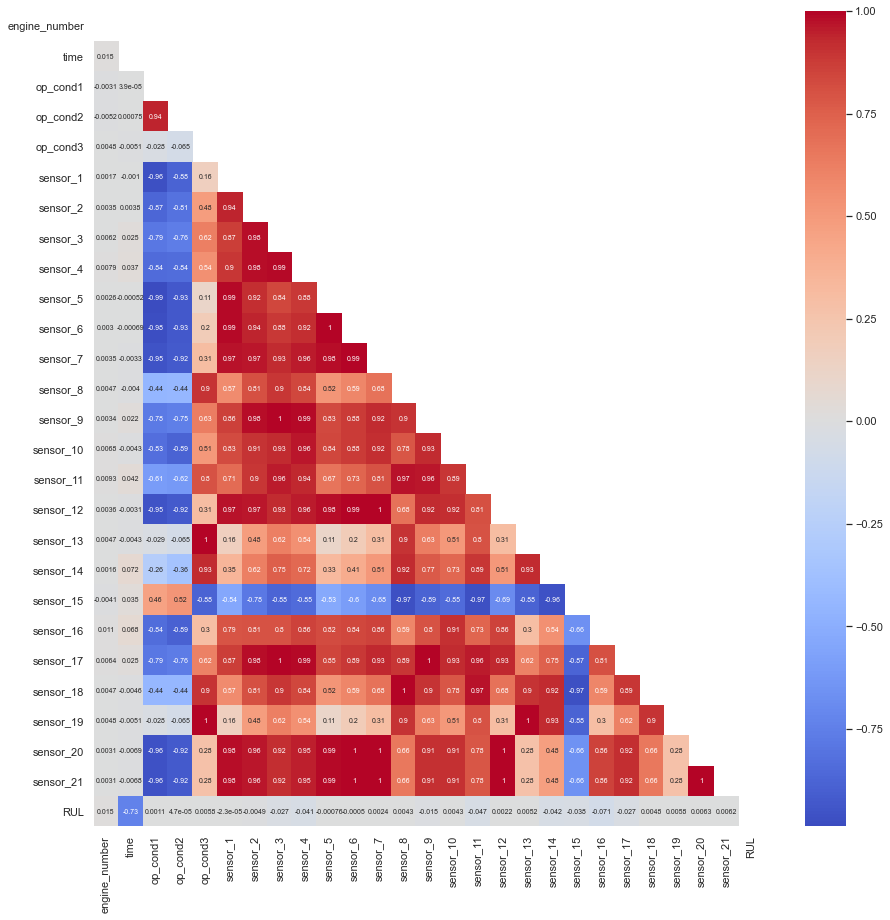

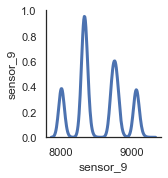

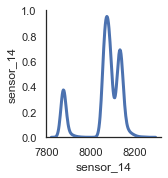

In [4]:
correlation_map = data_train.corr()

mask = np.zeros(correlation_map.shape, dtype=bool)
mask[np.triu_indices(len(mask))]=True

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlation_map,cmap='coolwarm',mask=mask,ax=ax,annot=True,annot_kws={'size':7})

sns.set(style='white')
df = data_train.loc[:,['sensor_9']]
g = sns.PairGrid(df,diag_sharey=False)
g.map_diag(sns.kdeplot,lw=3)

sns.set(style='white')
df = data_train.loc[:,['sensor_14']]
g = sns.PairGrid(df,diag_sharey=False)
g.map_diag(sns.kdeplot,lw=3)






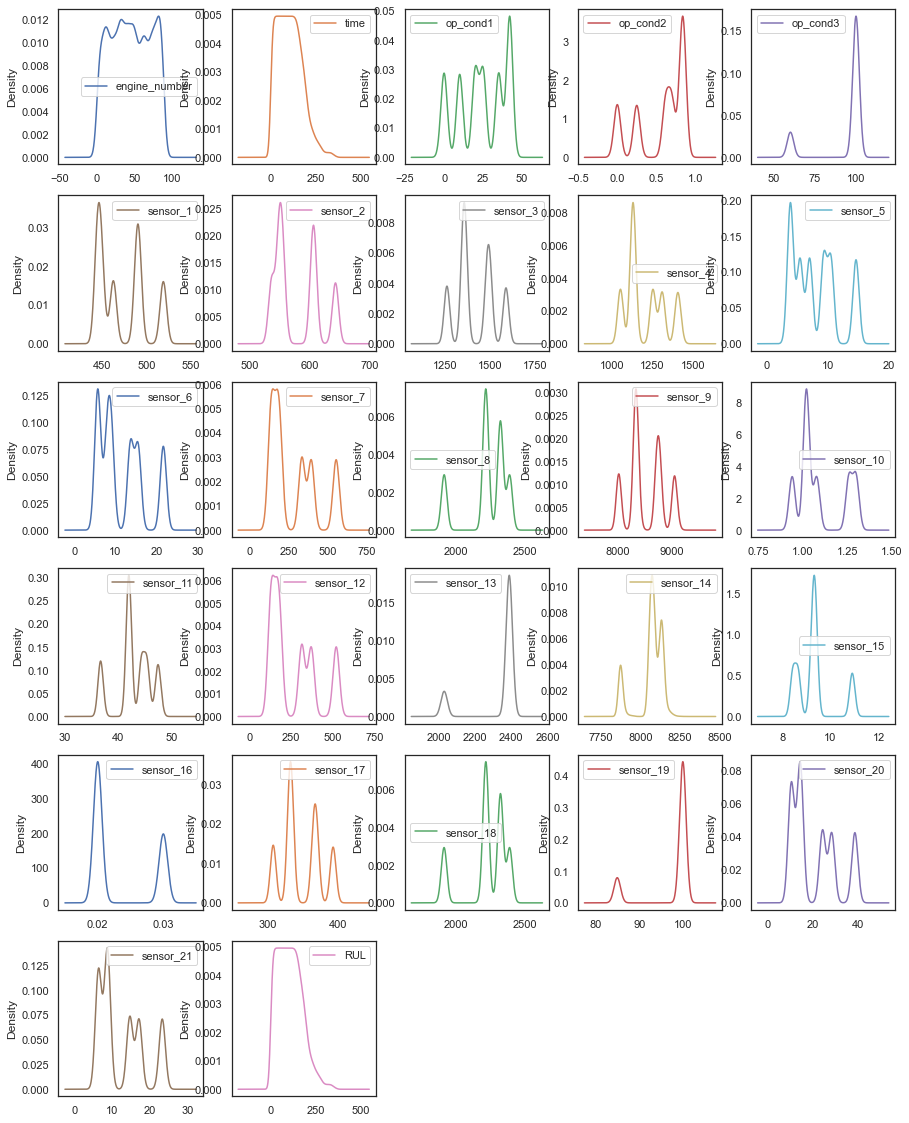

In [5]:
train.plot(kind='density',subplots=True, layout=(6,5),sharex=False, figsize=(15,20))
plt.show()

C:\Users\pc\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


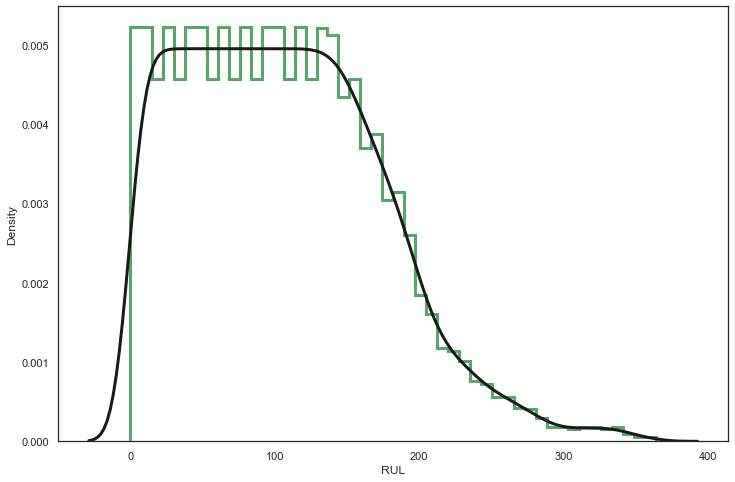

In [6]:
engine_of_train = train.groupby('engine_number')


drop = ['engine_number','time']
train_for_random = train.drop(columns=drop)

y=train_for_random['RUL']
x=train_for_random.drop(columns=['RUL'])
plt.figure(figsize=(12,8))
ax = sns.distplot(y,rug_kws={"color":"g"},
                  kde_kws={"color":"k","lw":3,"label":"RUL"},
                  hist_kws={"histtype":"step","linewidth":3,"alpha":1,"color":"g"})

# RANDOM FOREST AND CROSS VALIDATION

In [3]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor(n_estimators=250,max_depth=20,random_state=19)
rf.fit(x_train,y_train)
y_pred = rf.predict(X_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=rf, X=x_train, y=y_train, cv=5)

mae = mean_absolute_error(y_pred,Y_test)
mse = mean_squared_error(y_pred, Y_test)
rmse = np.sqrt(mse)
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)
print('Results from cross validation:',all_accuracies)

Mean Absolute Error (MAE): 38.67
Mean Squared Error (MSE): 2709.08
Root Mean Squared Error (RMSE): 52.05
Results from cross validation: [0.57489667 0.54757731 0.59152444 0.60284544 0.48912556]


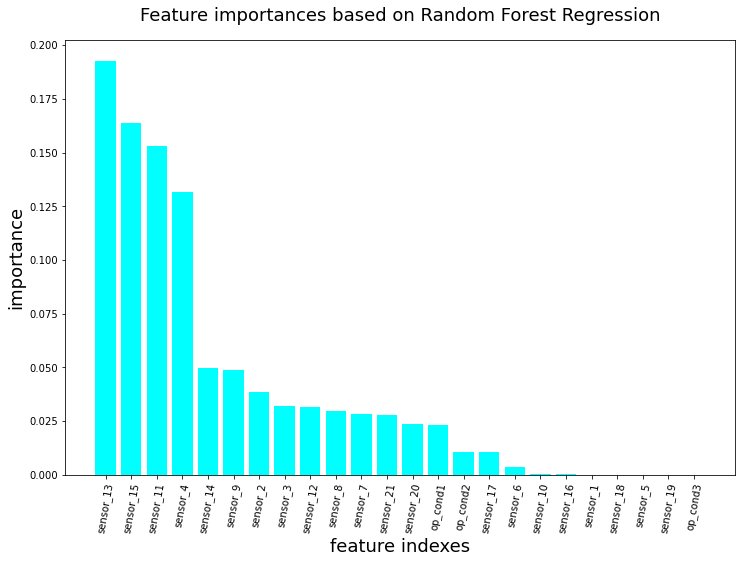

In [9]:
plt.figure(figsize=(12,8))
weights = rf.feature_importances_
features = np.argsort(weights)[::-1]
columns = x_train.columns
plt.title('Feature importances based on Random Forest Regression',y=1.03,size=18)
plt.bar(range(len(features)), weights[features], color="aqua", align="center")
plt.xticks(range(len(features)), columns[features], rotation=80)
plt.ylabel("importance", fontsize=18)
plt.xlabel("feature indexes", fontsize=18)
plt.show()
important_weights = pd.Series(data=rf.feature_importances_,index=x_train.columns)
important_weights.sort_values(ascending=False,inplace=True) 

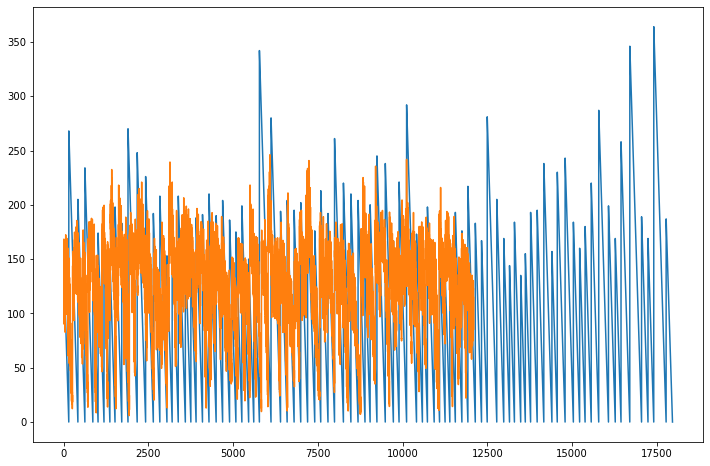

In [8]:
plt.figure(figsize=(12,8))
plt.plot(y_train)
plt.plot(y_pred)


No handles with labels found to put in legend.


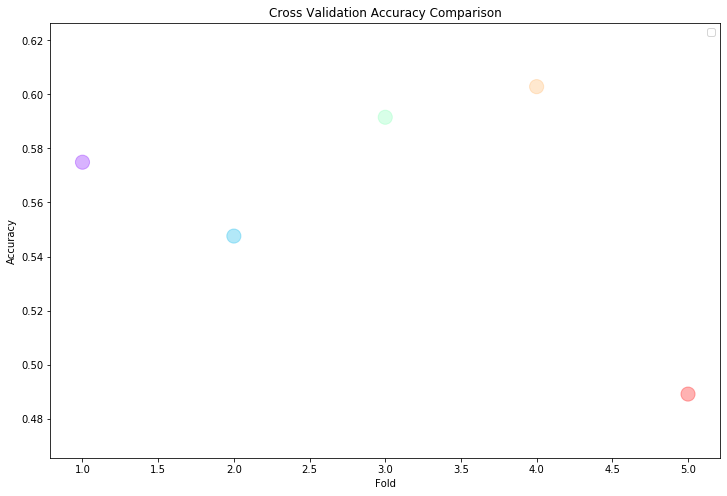

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
x = [0.57489667, 0.54757731, 0.59152444, 0.60284544, 0.48912556]
y=[1,2,3,4,5]
colors = cm.rainbow(np.linspace(0, 1, 5))
plt.scatter(y,x,s=200,c=colors,alpha=0.3)
plt.ylabel("Accuracy")
plt.xlabel("Fold")
plt.legend()
plt.title("Cross Validation Accuracy Comparison")
plt.show()

# Support Vector Machines

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state = 0)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(X_test)

# Naive Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_pred,Y_test)
mse = mean_squared_error(y_pred, Y_test)
rmse = np.sqrt(mse)
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)

Mean Absolute Error (MAE): 183.30
Mean Squared Error (MSE): 37634.83
Root Mean Squared Error (RMSE): 194.00


# NORMALIZATION

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
col = train.columns.difference(['engine_number','time','RUL'])
scalex = scaler.fit(train[col])
norm_train = pd.DataFrame(scalex.transform(train[col]),columns=col,index=train.index)
join_train = train[train.columns.difference(col)].join(norm_train)
train1 = join_train.reindex(columns=test.columns)

calex = scaler.fit(test[col])
norm_test = pd.DataFrame(scalex.transform(test[col]),columns=col,index=test.index)
join_test = test[test.columns.difference(col)].join(norm_test)
test1 = join_test.reindex(columns = test.columns)

seq_col = ['sensor_11', 'sensor_9', 'sensor_4', 'sensor_12', 'sensor_14',
        'sensor_7', 'sensor_15', 'sensor_21', 'sensor_3', 'sensor_2',
       'sensor_20', 'op_cond1', 'sensor_13', 'sensor_8', 'op_cond2', 'sensor_17']

def gen(df, seq_len, seq_cols):
     data_matrix = df[seq_cols].values
     num_element = data_matrix.shape[0]
     for start, stop in zip(range(0, num_element-seq_len), 
                            range(seq_len, num_element)):
         yield data_matrix[start:stop, :]

def gen_label(df, seq_len, label):
     data_matrix = df[label].values
     num_element = data_matrix.shape[0]
     return data_matrix[seq_len:num_element, :]

seq_len = 50

train_gen = (list(gen(train1[train1["engine_number"] == id], seq_len, seq_col)) 
              for id in train1["engine_number"].unique())
x_train = np.concatenate(list(train_gen)).astype(np.float32)


label_gen = [gen_label(train1[train1["engine_number"]==id], seq_len, ["RUL"]) 
             for id in train1["engine_number"].unique()] 

y_train = np.concatenate(label_gen).astype(np.float32)

seq_len_test = 54

seq_array = [test1[test1['engine_number']==id][seq_col].values[-seq_len_test:] 
                        for id in test1['engine_number'].unique() 
              if len(test1[test1['engine_number']==id]) >= seq_len_test]
x_test = np.asarray(seq_array).astype(np.float32)
y_mask = [len(test1[test1['engine_number']==id]) >= seq_len_test 
           for id in test1['engine_number'].unique()]
label_array = test1.groupby('engine_number')['RUL'].nth(-1)[y_mask].values

y_test = label_array.reshape(label_array.shape[0],1).astype(np.float32)

# BEGINNING OF STRUCTURE OF RNN

In [11]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Concatenate, Input,GRU, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

# BIDIRECTIONAL LSTM

In [ ]:
K.clear_session()

nb_features = x_train.shape[2]
nb_out = y_train.shape[1]



input = Input(shape =(None, nb_features))
x = Bidirectional(LSTM(units = 256, return_sequences=True))(input)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
x = Dropout(0.2)(x)
output = Dense(units=nb_out)(x)

model1 = Model(inputs = input, outputs = output)
model1.compile(loss='mean_squared_error', optimizer = "rmsprop" ,metrics=['mae'])
print(model1.summary())




from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau,CSVLogger

model_name = "model_1.hd5f"
model_path =  model_name
check = ModelCheckpoint(model_path, monitor = "val_loss", save_best_only = True)
lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0001, patience = 5, min_lr = 0.0005)

history = model1.fit(x_train, y_train, epochs=80, batch_size=200, validation_split=0.05, 
                      verbose=1,callbacks = [check, lr])

model1=load_model(model_name)

y_pred=model1.predict(x_train,verbose=1)


from sklearn.metrics import mean_absolute_error
mae = str(mean_absolute_error(y_train, y_pred))
print("Train MAE: " + mae)

#Test loss
y_pred = model1.predict(x_test, verbose=1)
mae = str(mean_absolute_error(y_test, y_pred))
print("Test MAE: " + mae)


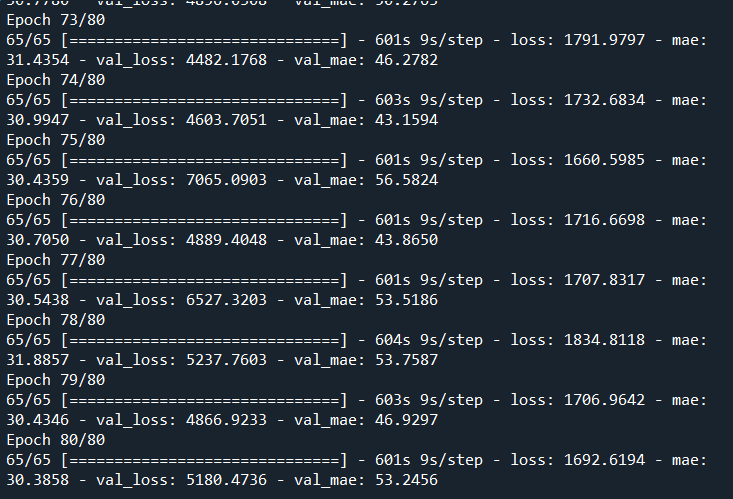

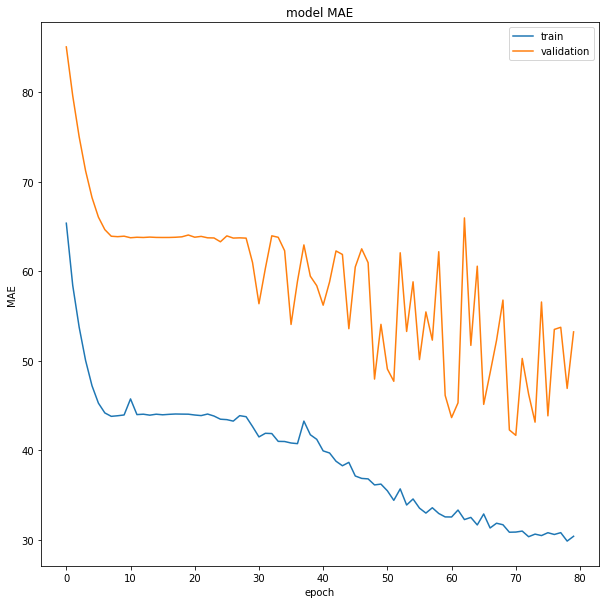

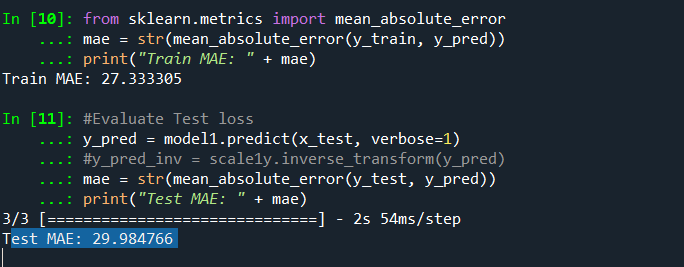

# LSTM

In [ ]:
input = Input(shape =(None, nb_features))
x = LSTM(units = 256, return_sequences=True)(input)
x = Dropout(0.2)(x)
x = LSTM(units=128, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(units=64, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(units=64, return_sequences=False)(x)
x = Dropout(0.2)(x)
output = Dense(units=nb_out)(x)

model2 = Model(inputs = input, outputs = output)
model2.compile(loss='mean_squared_error', optimizer = "rmsprop" ,metrics=['mae'])
print(model2.summary())
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau,CSVLogger

model_name2 = "model_2.hd5f"
model_path2 =  model_name2
check = ModelCheckpoint(model_path2, monitor = "val_loss", save_best_only = True)
lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0001, patience = 5, min_lr = 0.0005)

history = model2.fit(x_train, y_train, epochs=40, batch_size=100, validation_split=0.05, 
                     verbose=1,callbacks = [check, lr])



model2=load_model(model_name2)

y_pred=model2.predict(x_train,verbose=1)


from sklearn.metrics import mean_absolute_error
mae = str(mean_absolute_error(y_train, y_pred))
print("Train MAE: " + mae)

#Test loss
y_pred = model2.predict(x_test, verbose=1)
mae = str(mean_absolute_error(y_test, y_pred))
print("Test MAE: " + mae)

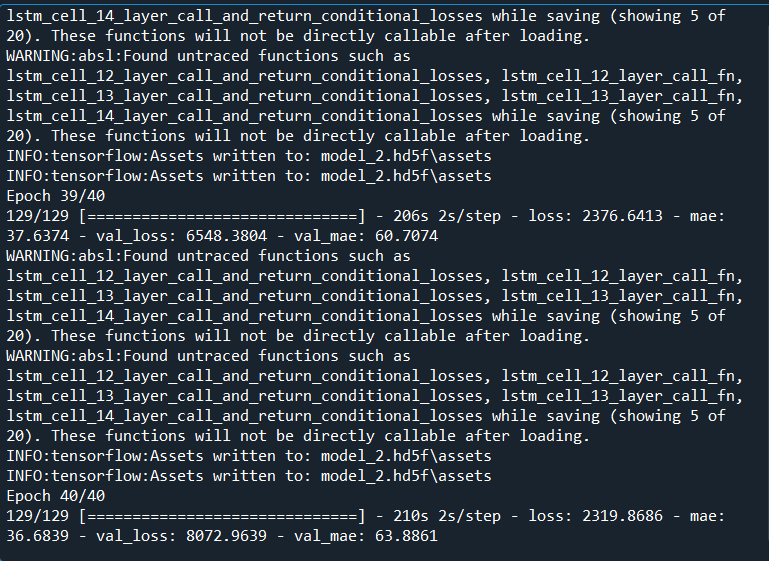

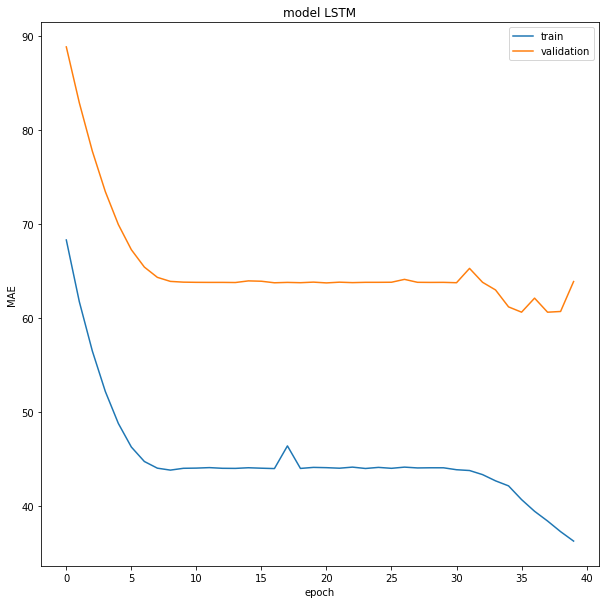

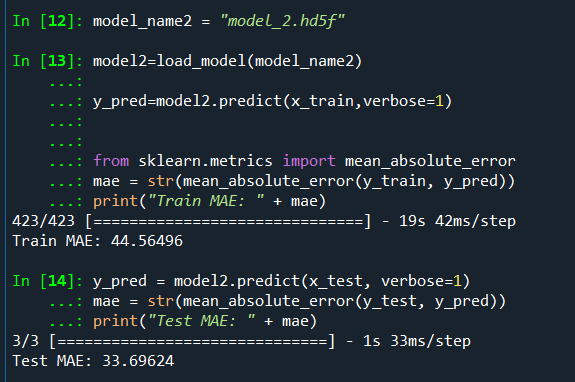

# COMPARISON TABLE

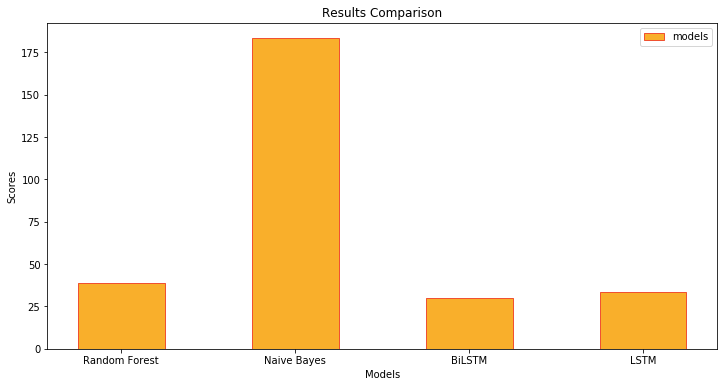

In [1]:
import matplotlib.pyplot as plt
import numpy as np
x = [38.67,183.30,29.984,33.696]
y=["Random Forest", "Naive Bayes", "BiLSTM", "LSTM"]
f=plt.figure(figsize=(12,6))

plt.bar(y,x,width=0.5,color="#f9af2b",edgecolor="#f05131",label="models")

plt.ylabel("Scores")
plt.xlabel("Models")
plt.legend()
plt.title("Results Comparison")
plt.show()